In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import r_regression
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import gradio as gr

In [2]:
df = pd.read_csv('clean_df.csv', index_col=0)
df.head()

,year,name,age,games_played,games_started,minutes_played,PER,TS%,3PAr,FTr,...,college_Western Michigan University,college_Wichita State University,college_William Paterson University,college_Wingate University,college_Winston-Salem State University,college_Wright State University,college_Xavier University,college_Xavier University of Louisiana,college_Yale University,all_nba_selections
0,1974,Zaid Abdul-Aziz,27.0,79,50,2459.0,15.9,0.516,0.0,0.328,...,0,0,0,0,0,0,0,0,0,0
1,1974,Kareem Abdul-Jabbar,26.0,81,72,3548.0,24.4,0.564,0.0,0.239,...,0,0,0,0,0,0,0,0,0,15
2,1974,Don Adams,26.0,74,46,2298.0,10.9,0.457,0.0,0.271,...,0,0,0,0,0,0,0,0,0,0
3,1974,Rick Adelman,27.0,55,12,618.0,10.0,0.447,0.0,0.447,...,0,0,0,0,0,0,0,0,0,0
4,1974,Lucius Allen,26.0,72,48,2388.0,18.8,0.536,0.0,0.258,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20529 entries, 0 to 20528
Columns: 618 entries, year to all_nba_selections
dtypes: float64(44), int64(573), object(1)
memory usage: 97.0+ MB


# Table of Contents
1. [KBest and Feature Reduction](#first-point)
2. [Logistic Regression](#second-point)
3. [PCA and Logistic Regression](#third-point)
4. [Pipeline and Grid Searching](#fourth-point)
5. [Model Evaluation with Unseen Data](#fifth-point)
6. [Model Evaluation with Testing Data](#sixth-point)
7. [Conclusion](#seventh-point)
8. [Gradio Launch](#eighth-point)

After some research, the college and birth state are not helpful. There are usually just 1 or 2 players from that state/college that were really good and it skews the data. Therefore, we will drop all college and birth state columns.

We'll also drop team as that does not help with prediction.

In [4]:
df = df.drop(df.filter(regex='college').columns, axis=1)
df = df.drop(df.filter(regex='birth_state').columns, axis=1)
df = df.drop(df.filter(regex='team_').columns, axis=1)
df.head()

,year,name,age,games_played,games_started,minutes_played,PER,TS%,3PAr,FTr,...,career_position_G-F,career_position_PF,career_position_PF-C,career_position_PG,career_position_PG-SG,career_position_SF,career_position_SF-PF,career_position_SF-SG,career_position_SG,all_nba_selections
0,1974,Zaid Abdul-Aziz,27.0,79,50,2459.0,15.9,0.516,0.0,0.328,...,0,0,0,0,0,0,0,0,0,0
1,1974,Kareem Abdul-Jabbar,26.0,81,72,3548.0,24.4,0.564,0.0,0.239,...,0,0,0,0,0,0,0,0,0,15
2,1974,Don Adams,26.0,74,46,2298.0,10.9,0.457,0.0,0.271,...,0,0,0,0,0,0,0,0,0,0
3,1974,Rick Adelman,27.0,55,12,618.0,10.0,0.447,0.0,0.447,...,0,0,0,0,0,0,0,0,0,0
4,1974,Lucius Allen,26.0,72,48,2388.0,18.8,0.536,0.0,0.258,...,0,0,0,0,0,0,0,0,0,0


Finally, we need to convert the `all_nba_selections` column to 0s, 1s and 2s. Here's the key:
- `0` = The player never made an All-NBA team
- `1` = The player made an All-NBA team

In [5]:
# Convert all_nba_selections column - Only need to change numbers higher than 1
df.loc[df['all_nba_selections']>0, 'all_nba_selections'] = 1

In [6]:
df.to_csv('its_the_df_testing.csv')

Now, we'll split the data into train and test sets for feature engineering.

In [7]:
# 1. Load data
X = df.drop(columns=['all_nba_selections', 'name', 'year'])
y = df['all_nba_selections']

# 2. Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 3. Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## KBest and Feature Reduction<a name="first-point"></a>

We have way too many features (over 600). Let's reduce it to the top 30 that impact hall of fame status the most.

In [8]:
my_KBest = SelectKBest(f_classif, k=30).fit(X_train, y_train)
X_train_selected = my_KBest.transform(X_train)
X_test_selected = my_KBest.transform(X_test)
my_KBest.get_support()

array([False,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True, False, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True, False, False,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

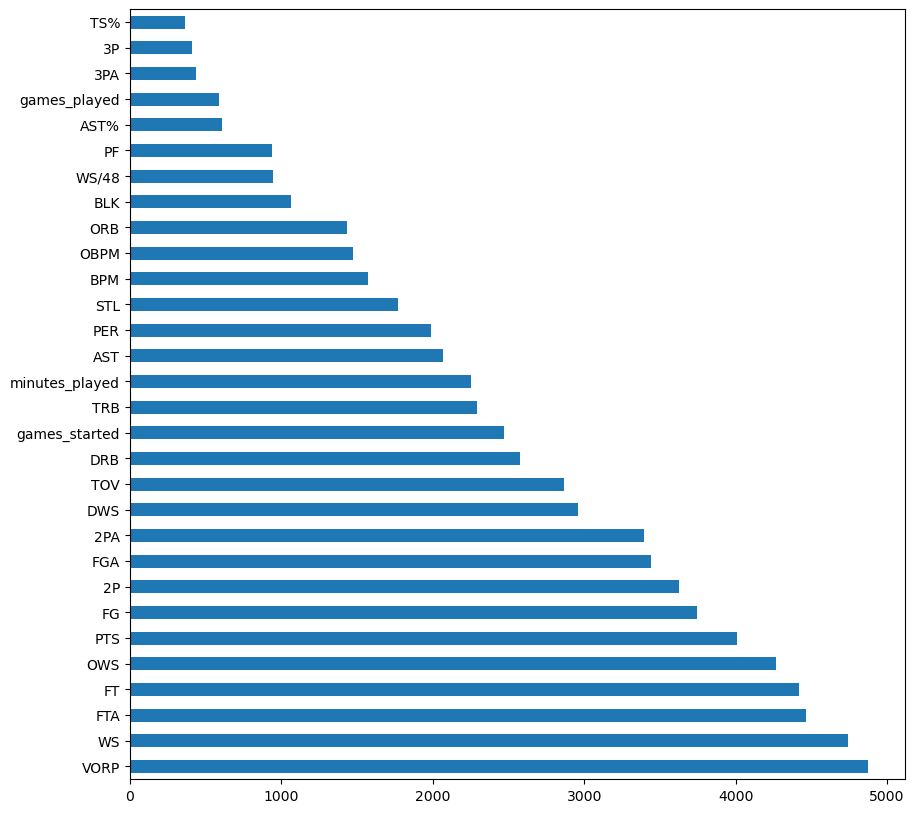

In [9]:
pd.Series(index=X.columns, data=my_KBest.scores_).sort_values(ascending=False).head(30).plot(kind='barh', figsize=(10,10))
plt.show()

In [10]:
# Display dataframe with top 30 features
cols_indx = my_KBest.get_support(True)
new_df = X.iloc[:, cols_indx]
new_df = pd.concat([df['name'], new_df, y], axis=1)
pd.set_option('display.max_columns', None)
new_df.head()

,name,games_played,games_started,minutes_played,PER,TS%,AST%,OWS,DWS,WS,WS/48,OBPM,BPM,VORP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,all_nba_selections
0,Zaid Abdul-Aziz,79,50,2459.0,15.9,0.516,8.9,3.3,3.2,6.5,0.126,-0.7,1.0,1.8,336.0,732.0,0.0,0.0,336.0,732.0,193.0,240.0,259.0,664.0,923.0,166.0,80.0,104.0,78.525194,227.0,865.0,0
1,Kareem Abdul-Jabbar,81,72,3548.0,24.4,0.564,16.1,10.6,7.9,18.4,0.250,4.9,8.5,9.4,948.0,1759.0,0.0,0.0,948.0,1759.0,295.0,420.0,287.0,891.0,1178.0,386.0,112.0,283.0,61.817947,238.0,2191.0,1
2,Don Adams,74,46,2298.0,10.9,0.457,8.3,0.1,3.5,3.6,0.076,-2.6,-1.1,0.5,303.0,742.0,0.0,0.0,303.0,742.0,153.0,201.0,133.0,315.0,448.0,141.0,110.0,12.0,61.516681,242.0,759.0,0
3,Rick Adelman,55,12,618.0,10.0,0.447,12.4,-0.3,0.9,0.7,0.053,-3.8,-3.0,-0.2,64.0,170.0,0.0,0.0,64.0,170.0,54.0,76.0,16.0,53.0,69.0,56.0,36.0,1.0,79.688357,63.0,182.0,0
4,Lucius Allen,72,48,2388.0,18.8,0.536,21.7,4.7,3.4,8.2,0.164,3.1,3.6,3.4,526.0,1062.0,0.0,0.0,526.0,1062.0,216.0,274.0,89.0,202.0,291.0,374.0,137.0,22.0,79.688357,215.0,1268.0,0


Now that we have that, let's create a dataframe where each row is a unique player.

In [11]:
unique_names = [name for name in new_df['name'].unique()] # List of unique names
delete_cols = ['age'] # Remove age as that's not helpful for this dataframe

# Columns that need to be summed together for consolidating rows
sum_cols = ['FTA', 'FT', 'PTS', 'FG', '2P', 'FGA', '2PA', 'TOV', 'DRB', 'AST', 'TRB', 'games_started', 
           'minutes_played', 'STL', 'BLK', 'ORB', 'PF', '3PA', '3P', 'games_played']

# Columns that need to be averaged together for consolidating rows
avg_cols = ['VORP', 'WS', 'OWS', 'PER', 'BPM', 'OBPM', 'WS/48', 'AST%', 'TS%',
           'all_nba_selections', 'DWS']

# Show final dataframe
final_df = pd.DataFrame(unique_names, columns=['name'])
final_df.head()

,name
0,Zaid Abdul-Aziz
1,Kareem Abdul-Jabbar
2,Don Adams
3,Rick Adelman
4,Lucius Allen


In [13]:
# Create each column
for sum_col in sum_cols:
    final_df[sum_col] = None
    
for avg_col in avg_cols:
    final_df[avg_col] = None

In [14]:
# Sanity check before filling in values for each column
final_df.head()

,name,FTA,FT,PTS,FG,2P,FGA,2PA,TOV,DRB,AST,TRB,games_started,minutes_played,STL,BLK,ORB,PF,3PA,3P,games_played,VORP,WS,OWS,PER,BPM,OBPM,WS/48,AST%,TS%,all_nba_selections,DWS
0,Zaid Abdul-Aziz,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Kareem Abdul-Jabbar,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Don Adams,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Rick Adelman,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Lucius Allen,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [16]:
# Go through each unique name to fill in missing values in final_df

for final_name in final_df['name']: # Go through each unique name in final_df
    for name in new_df['name']: # Go through each row in new_df
        
        if final_name==name: # If the names match...
            
            # Sum matching rows for each 'sum column'
            for sum_index in range(len(sum_cols)):
                temp_sum = new_df.loc[new_df['name']==final_name, sum_cols[sum_index]].sum() # Sum
                final_df.loc[final_df['name']==final_name, sum_cols[sum_index]] = temp_sum # Add sum to column at correct name
            
            # Average matching rows for each 'average column'
            for avg_index in range(len(avg_cols)):
                temp_avg = new_df.loc[new_df['name']==final_name, avg_cols[avg_index]].mean() # Average
                final_df.loc[final_df['name']==final_name, avg_cols[avg_index]] = temp_avg # Add avg to column at correct name
                
        else:
            pass
                

In [17]:
# Make sum columns on a per-game basis

for col in sum_cols:
    if col != 'games_played':
        final_df[col] = final_df[col] / final_df['games_played']

In [18]:
# Sanity check
final_df.head()

,name,FTA,FT,PTS,FG,2P,FGA,2PA,TOV,DRB,AST,TRB,games_started,minutes_played,STL,BLK,ORB,PF,3PA,3P,games_played,VORP,WS,OWS,PER,BPM,OBPM,WS/48,AST%,TS%,all_nba_selections,DWS
0,Zaid Abdul-Aziz,2.493333,1.933333,7.951111,3.008889,3.008889,6.84,6.84,1.520448,5.133333,1.302222,7.453333,0.404444,20.635556,0.595556,0.924444,2.32,2.057778,0.0,0.0,225,0.271429,1.614286,0.785714,14.285714,-2.485714,-2.171429,0.066857,9.114286,0.453571,0.0,0.814286
1,Kareem Abdul-Jabbar,5.397902,3.97498,22.853914,9.439064,9.438257,16.838579,16.824052,2.239122,7.581921,3.472155,9.983051,0.900726,35.340597,0.936239,2.57385,2.40113,2.959645,0.014528,0.000807,1239,5.36875,11.86875,7.5,23.2375,5.33125,3.51875,0.202188,14.0875,0.593063,1.0,4.38125
2,Don Adams,1.972868,1.422481,6.949612,2.763566,2.763566,6.794574,6.794574,0.953747,3.271318,1.70155,4.682171,0.472868,23.596899,1.096899,0.213178,1.410853,2.906977,0.0,0.0,258,0.05,1.5,-0.25,10.025,-2.2,-3.125,0.0405,10.225,0.44925,0.0,1.75
3,Rick Adelman,1.649123,1.169591,4.795322,1.812865,1.812865,4.397661,4.397661,2.330069,1.128655,1.637427,1.51462,0.309942,16.175439,1.02924,0.099415,0.385965,1.549708,0.0,0.0,171,-0.06,0.66,0.02,10.72,-2.58,-3.0,0.0622,13.44,0.4722,0.0,0.64
4,Lucius Allen,3.530043,2.740343,15.285408,6.272532,6.272532,13.864807,13.864807,1.556073,2.39485,4.901288,3.405579,0.624464,31.167382,1.587983,0.328326,1.01073,2.800429,0.0,0.0,466,1.1875,3.3,1.775,15.3125,-0.05,0.6375,0.075,21.75,0.48375,0.0,1.525


In [20]:
# Convert data type to float
for col in final_df.drop(columns=['name']).columns:
    final_df[col] = final_df[col].astype('float')

In [21]:
# Sanity check
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3117 entries, 0 to 3116
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                3117 non-null   object 
 1   FTA                 3117 non-null   float64
 2   FT                  3117 non-null   float64
 3   PTS                 3117 non-null   float64
 4   FG                  3117 non-null   float64
 5   2P                  3117 non-null   float64
 6   FGA                 3117 non-null   float64
 7   2PA                 3117 non-null   float64
 8   TOV                 3117 non-null   float64
 9   DRB                 3117 non-null   float64
 10  AST                 3117 non-null   float64
 11  TRB                 3117 non-null   float64
 12  games_started       3117 non-null   float64
 13  minutes_played      3117 non-null   float64
 14  STL                 3117 non-null   float64
 15  BLK                 3117 non-null   float64
 16  ORB   

## Logistic Regression<a name="second-point"></a>

Let's run a simple logistic regression to get a baseline of model performance.

In [22]:
# Create copy df to not mess with the final_df
testing_df = final_df.copy()

In [89]:
# Split
X = testing_df.drop(columns=['all_nba_selections', 'name'])
y = testing_df['all_nba_selections']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
   
# Run initial regression model to see performance without much work
model = LogisticRegression()

model.fit(X_train, y_train)
    
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9628610729023384
0.9764957264957265


/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
# See how SelectKBest performs with different k values
train_acc = []
test_acc = []

for k in range(1, X.shape[1]):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_ss = scaler.transform(X_train)
    X_test_ss = scaler.transform(X_test)
    
    my_KBest = SelectKBest(k=k).fit(X_train_ss, y_train)
    
    X_train_selected = my_KBest.transform(X_train_ss)
    X_test_selected = my_KBest.transform(X_test_ss)
    
    model = LogisticRegression()
    model.fit(X_train_selected, y_train)
    
    train_acc.append(model.score(X_train_selected, y_train))
    test_acc.append(model.score(X_test_selected, y_test))

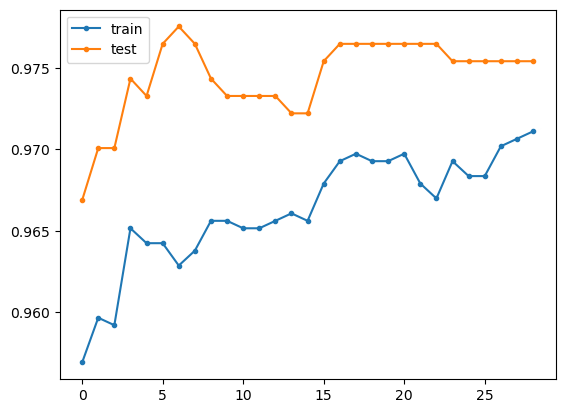

In [91]:
plt.figure()
plt.plot(train_acc, label='train', marker='.')
plt.plot(test_acc, label='test', marker='.')
plt.legend()
plt.show()

In [96]:
# Plot best performing model at k = 7

# Scale
first_scaler = StandardScaler()
first_scaler.fit(X_train)
    
X_train_ss = first_scaler.transform(X_train)
X_test_ss = first_scaler.transform(X_test)

# Feature engineering
my_KBest = SelectKBest(score_func=r_regression, k=7).fit(X_train_ss, y_train)
    
X_train_selected = my_KBest.transform(X_train_ss)
X_test_selected = my_KBest.transform(X_test_ss)

# Model
first_model = LogisticRegression(max_iter=10000)
first_model.fit(X_train_selected, y_train)

# Test score on scaled and engineered test set
print(first_model.score(X_test_selected, y_test))

# Test score on non-scaled and non-engineered test set
first_model.fit(X_train, y_train)
print(first_model.score(X_test, y_test))

0.9775641025641025
0.9754273504273504


In [27]:
# Check percent of All-NBA rows
(final_df['all_nba_selections']!=0).sum() / len(final_df['all_nba_selections'])

0.05838947706127687

This shows me that about 5.8% of players in my dataset made an All-NBA team. This means that 94.2% of players never made an All-NBA team. Therefore, scoring a 97.8% is better than chance but we'd like to see better results. We will try using different pre-processing techniques to find a better solution.

There seems to be a jump in performance at 19 and 20 features seem to be the best performers in our Logistic Regression model. Since 19 has a lower train score but an equally good test score, we will choose that in order to reduce risk for overfitting.

In [28]:
my_KBest.scores_

array([0.55534055, 0.55588517, 0.54387056, 0.52965642, 0.51906102,
       0.51384903, 0.50698365, 0.12066778, 0.43134172, 0.39829453,
       0.4034182 , 0.4673459 , 0.44227304, 0.36838213, 0.27672009,
       0.301007  , 0.26317908, 0.16584872, 0.17066155, 0.31009226,
       0.61355953, 0.59606894, 0.58459067, 0.2989941 , 0.28413544,
       0.27689579, 0.21638814, 0.18370831, 0.15687076, 0.50534709])

## PCA and Logistic Regression<a name="third-point"></a>

We'll run this same process but with a PCA feature engineering to see how the two different methods compare.

In [29]:
train_acc = []
test_acc = []

for compos in range(1, 30):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_ss = scaler.transform(X_train)
    X_test_ss = scaler.transform(X_test)
    
    my_pca = PCA(n_components=compos).fit(X_train_ss, y_train)
    
    X_train_selected = my_pca.transform(X_train_ss)
    X_test_selected = my_pca.transform(X_test_ss)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_selected, y_train)
    
    train_acc.append(model.score(X_train_selected, y_train))
    test_acc.append(model.score(X_test_selected, y_test))

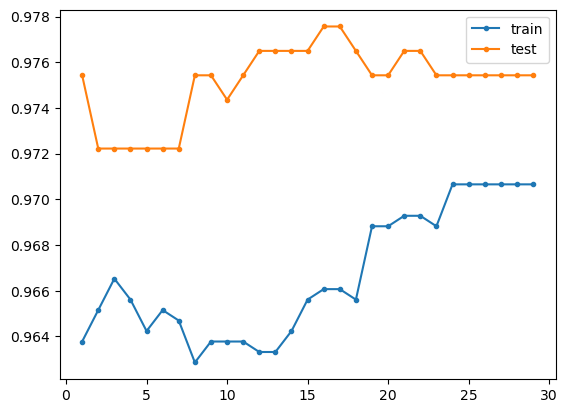

In [30]:
plt.figure()
plt.plot(range(1, 30), train_acc, label='train', marker='.')
plt.plot(range(1, 30), test_acc, label='test', marker='.')
plt.legend()
plt.show()

16 components seems to be our best model.

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
    
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)

my_pca = PCA(n_components=16).fit(X_train_ss, y_train)
    
X_train_selected = my_pca.transform(X_train_ss)
X_test_selected = my_pca.transform(X_test_ss)
    
model = LogisticRegression(max_iter=10000)
model.fit(X_train_selected, y_train)
    
print(f'Train Score: {model.score(X_train_selected, y_train)}')
print(f'Test Score: {model.score(X_test_selected, y_test)}')

cv_score = np.mean(cross_val_score(model, X_train_selected, y_train, cv=5))
print(f'CV score: {cv_score}')

Train Score: 0.9660706098120129
Test Score: 0.9775641025641025
CV score: 0.96377826296895


We score about a 97.8% on this. This is nearly exactly the same score as our model using SelectKBest.

## Pipeline and Grid Searching<a name="fourth-point"></a>

We'll test multiple models using the Pipeline and Grid Searching.

First, we are going to take 20 players out of this dataframe altogether for testing our best model. We'll take 10 with positive hall of fame status (1) and 10 with negative hall of fame status (0).

In [32]:
temp_all_nba_df = testing_df.loc[testing_df['all_nba_selections']!=0, :]
temp_all_nba_df

,name,FTA,FT,PTS,FG,2P,FGA,2PA,TOV,DRB,AST,TRB,games_started,minutes_played,STL,BLK,ORB,PF,3PA,3P,games_played,VORP,WS,OWS,PER,BPM,OBPM,WS/48,AST%,TS%,all_nba_selections,DWS
1,Kareem Abdul-Jabbar,5.397902,3.974980,22.853914,9.439064,9.438257,16.838579,16.824052,2.239122,7.581921,3.472155,9.983051,0.900726,35.340597,0.936239,2.573850,2.401130,2.959645,0.014528,0.000807,1239.0,5.36875,11.868750,7.500000,23.237500,5.331250,3.518750,0.202188,14.087500,0.593063,1.0,4.381250
5,Tiny Archibald,5.813480,4.683386,16.158307,5.722571,5.692790,12.407524,12.274295,2.259802,1.590909,6.920063,2.130094,0.755486,33.446708,1.126959,0.126959,0.539185,2.161442,0.133229,0.029781,638.0,0.95000,5.120000,3.620000,15.940000,-0.730000,1.460000,0.104700,29.060000,0.538200,1.0,1.490000
10,Rick Barry,4.212996,3.859206,21.171480,8.590253,8.458484,19.124549,18.725632,1.480265,4.270758,5.709386,5.191336,0.714801,35.351986,1.992780,0.485560,0.920578,2.642599,0.398917,0.131769,554.0,3.70000,8.342857,5.242857,19.128571,2.971429,2.828571,0.138429,23.385714,0.505286,1.0,3.114286
16,Dave Bing,4.549223,3.655440,15.831606,6.088083,6.088083,13.779793,13.779793,1.385372,1.919689,5.782383,3.002591,0.683938,33.841969,1.251295,0.230570,1.082902,2.841969,0.000000,0.000000,386.0,1.72000,5.080000,3.020000,15.640000,0.400000,1.480000,0.092600,24.720000,0.502400,1.0,2.060000
34,Phil Chenier,3.554371,2.895522,16.765458,6.923241,6.899787,15.579957,15.522388,1.131670,2.558635,2.825160,3.379531,0.626866,31.362473,1.524520,0.539446,0.820896,1.805970,0.057569,0.023454,469.0,0.86000,3.250000,1.430000,12.440000,-2.650000,-1.700000,0.057600,13.000000,0.463900,1.0,1.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,Karl-Anthony Towns,4.286585,3.530488,21.731707,8.701220,7.902439,16.048780,13.835366,2.408537,8.170732,2.323171,11.371951,1.000000,34.493902,0.701220,1.469512,3.201220,2.963415,2.213415,0.798780,164.0,4.25000,10.500000,7.650000,24.250000,3.900000,3.200000,0.176000,12.250000,0.604000,1.0,2.800000
3039,Jaylen Brown,1.589744,1.089744,6.602564,2.461538,1.871795,5.423077,3.692308,0.871795,2.243590,0.820513,2.820513,0.256410,17.192308,0.448718,0.230769,0.576923,1.820513,1.730769,0.589744,78.0,-0.70000,1.500000,0.200000,10.300000,-4.000000,-3.100000,0.053000,7.200000,0.539000,1.0,1.300000
3049,Joel Embiid,7.870968,6.161290,20.225806,6.451613,5.290323,13.838710,10.677419,3.774194,5.870968,2.129032,7.838710,1.000000,25.354839,0.870968,2.451613,1.967742,3.612903,3.161290,1.161290,31.0,1.00000,1.900000,0.500000,24.100000,3.200000,0.000000,0.117000,16.000000,0.584000,1.0,1.500000
3096,Domantas Sabonis,0.827160,0.543210,5.913580,2.370370,1.740741,5.938272,3.975309,1.024691,2.987654,1.012346,3.543210,0.814815,20.148148,0.481481,0.395062,0.555556,2.469136,1.962963,0.629630,81.0,-1.20000,0.700000,-1.000000,6.900000,-4.900000,-4.700000,0.022000,7.200000,0.469000,1.0,1.800000


In [33]:
temp_not_all_nba_df = testing_df.loc[testing_df['all_nba_selections']==0, :]
temp_not_all_nba_df

,name,FTA,FT,PTS,FG,2P,FGA,2PA,TOV,DRB,AST,TRB,games_started,minutes_played,STL,BLK,ORB,PF,3PA,3P,games_played,VORP,WS,OWS,PER,BPM,OBPM,WS/48,AST%,TS%,all_nba_selections,DWS
0,Zaid Abdul-Aziz,2.493333,1.933333,7.951111,3.008889,3.008889,6.840000,6.840000,1.520448,5.133333,1.302222,7.453333,0.404444,20.635556,0.595556,0.924444,2.320000,2.057778,0.000000,0.000000,225.0,0.271429,1.614286,0.785714,14.285714,-2.485714,-2.171429,0.066857,9.114286,0.453571,0.0,0.814286
2,Don Adams,1.972868,1.422481,6.949612,2.763566,2.763566,6.794574,6.794574,0.953747,3.271318,1.701550,4.682171,0.472868,23.596899,1.096899,0.213178,1.410853,2.906977,0.000000,0.000000,258.0,0.050000,1.500000,-0.250000,10.025000,-2.200000,-3.125000,0.040500,10.225000,0.449250,0.0,1.750000
3,Rick Adelman,1.649123,1.169591,4.795322,1.812865,1.812865,4.397661,4.397661,2.330069,1.128655,1.637427,1.514620,0.309942,16.175439,1.029240,0.099415,0.385965,1.549708,0.000000,0.000000,171.0,-0.060000,0.660000,0.020000,10.720000,-2.580000,-3.000000,0.062200,13.440000,0.472200,0.0,0.640000
4,Lucius Allen,3.530043,2.740343,15.285408,6.272532,6.272532,13.864807,13.864807,1.556073,2.394850,4.901288,3.405579,0.624464,31.167382,1.587983,0.328326,1.010730,2.800429,0.000000,0.000000,466.0,1.187500,3.300000,1.775000,15.312500,-0.050000,0.637500,0.075000,21.750000,0.483750,0.0,1.525000
6,Dennis Awtrey,1.406143,0.945392,4.296928,1.675768,1.675768,3.699659,3.699659,0.928791,2.769625,2.000000,4.040956,0.382253,18.996587,0.344710,0.332765,1.271331,2.085324,0.000000,0.000000,586.0,0.200000,1.290909,0.272727,7.900000,-2.145455,-3.109091,0.047909,12.045455,0.491455,0.0,0.990909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,Troy Williams,1.066667,0.700000,6.166667,2.433333,1.833333,5.566667,3.500000,1.100000,1.800000,0.833333,2.300000,0.533333,18.566667,0.900000,0.333333,0.500000,2.000000,2.066667,0.600000,60.0,-0.066667,0.200000,-0.266667,9.766667,-2.500000,-2.566667,0.049000,6.866667,0.533667,0.0,0.466667
3113,Kyle Wiltjer,0.142857,0.071429,0.928571,0.285714,0.000000,1.000000,0.071429,0.357143,0.428571,0.142857,0.714286,0.000000,3.142857,0.214286,0.071429,0.285714,0.285714,0.928571,0.285714,14.0,0.000000,0.000000,-0.100000,6.700000,-4.000000,-4.000000,-0.039000,6.100000,0.437000,0.0,0.100000
3114,Stephen Zimmerman,0.263158,0.157895,1.210526,0.526316,0.526316,1.631579,1.631579,0.157895,1.263158,0.210526,1.842105,0.000000,5.684211,0.105263,0.263158,0.578947,0.894737,0.000000,0.000000,19.0,-0.100000,0.000000,-0.100000,7.300000,-7.300000,-7.800000,-0.005000,5.300000,0.346000,0.0,0.100000
3115,Paul Zipser,0.909091,0.704545,5.454545,2.000000,1.250000,5.022727,2.772727,0.909091,2.500000,0.818182,2.840909,0.409091,19.159091,0.340909,0.363636,0.340909,1.772727,2.250000,0.750000,44.0,-0.400000,0.500000,-0.300000,6.900000,-3.700000,-3.600000,0.030000,6.100000,0.503000,0.0,0.800000


In [34]:
all_nba_index_list = []
not_all_nba_index_list = []

for i in range(10):
    rand_all_nba_num = np.random.choice(temp_all_nba_df.index.to_list())
    rand_not_all_nba_num = np.random.choice(temp_not_all_nba_df.index.to_list())
    
    all_nba_index_list.append(rand_all_nba_num)
    not_all_nba_index_list.append(rand_not_all_nba_num)
    

In [35]:
print(all_nba_index_list)
print(not_all_nba_index_list)

[5, 756, 3096, 2203, 1711, 64, 342, 2168, 1225, 397]
[2835, 2005, 144, 2269, 307, 2886, 1927, 2302, 1844, 1355]


In [36]:
untouched_index_list = all_nba_index_list + not_all_nba_index_list

untouched_test_set = testing_df.iloc[untouched_index_list]
untouched_test_set

,name,FTA,FT,PTS,FG,2P,FGA,2PA,TOV,DRB,AST,TRB,games_started,minutes_played,STL,BLK,ORB,PF,3PA,3P,games_played,VORP,WS,OWS,PER,BPM,OBPM,WS/48,AST%,TS%,all_nba_selections,DWS
5,Tiny Archibald,5.813480,4.683386,16.158307,5.722571,5.692790,12.407524,12.274295,2.259802,1.590909,6.920063,2.130094,0.755486,33.446708,1.126959,0.126959,0.539185,2.161442,0.133229,0.029781,638.0,0.950000,5.120000,3.620000,15.940000,-0.730000,1.460000,0.104700,29.060000,0.538200,1.0,1.490000
756,Fat Lever,3.074468,2.371011,13.873670,5.643617,5.428191,12.638298,11.942819,1.956117,4.097074,6.244681,6.014628,0.796543,31.667553,2.215426,0.277926,1.917553,2.397606,0.695479,0.215426,752.0,3.054545,5.563636,2.681818,16.945455,2.727273,0.981818,0.107091,25.036364,0.489364,1.0,2.881818
3096,Domantas Sabonis,0.827160,0.543210,5.913580,2.370370,1.740741,5.938272,3.975309,1.024691,2.987654,1.012346,3.543210,0.814815,20.148148,0.481481,0.395062,0.555556,2.469136,1.962963,0.629630,81.0,-1.200000,0.700000,-1.000000,6.900000,-4.900000,-4.700000,0.022000,7.200000,0.469000,1.0,1.800000
2203,Al Jefferson,3.182025,2.255973,16.030717,6.882821,6.873720,13.806598,13.734926,1.353811,6.283276,1.498294,8.585893,0.739477,29.368601,0.696246,1.217292,2.302617,2.594994,0.071672,0.009101,879.0,1.130769,5.338462,2.800000,20.053846,-0.169231,-0.546154,0.127308,9.453846,0.527462,1.0,2.530769
1711,Ben Wallace,2.455172,1.018103,5.691379,2.333621,2.327586,4.976724,4.929310,0.972414,6.386207,1.329310,9.556897,0.848276,29.560345,1.256034,1.943103,3.170690,1.895690,0.047414,0.006034,1160.0,2.755556,5.394444,1.283333,14.144444,2.505556,-2.305556,0.117167,6.094444,0.461222,1.0,4.116667
64,Walt Frazier,4.242340,3.473538,18.749304,7.637883,7.637883,15.947075,15.944290,1.275079,4.242340,5.649025,5.364903,0.763231,37.955432,1.896936,0.175487,1.122563,2.568245,0.002786,0.000000,359.0,2.985714,5.628571,3.457143,16.700000,1.828571,1.514286,0.101286,22.985714,0.505429,1.0,2.171429
342,Adrian Dantley,8.671183,7.075881,23.734417,8.326107,8.319783,15.540199,15.502258,2.697006,3.435411,2.939476,5.774164,0.855465,35.687444,0.998193,0.168925,2.338753,2.682023,0.037940,0.006323,1107.0,2.631579,8.105263,6.657895,20.373684,2.300000,3.652632,0.177263,12.489474,0.600053,1.0,1.426316
2168,Dwyane Wade,7.695082,5.910383,23.297268,8.457923,7.986885,17.459016,15.817486,3.300546,3.559563,5.653552,4.805464,0.987978,35.357377,1.639344,0.874317,1.245902,2.279781,1.641530,0.471038,915.0,4.142857,8.371429,5.250000,23.942857,4.721429,3.771429,0.167357,30.614286,0.556714,1.0,3.128571
1225,Drazen Petrovic,3.085470,2.592593,14.484330,5.549858,4.757835,11.002849,9.156695,1.928775,1.390313,2.242165,2.219373,0.424501,24.740741,0.877493,0.079772,0.829060,2.515670,1.846154,0.792023,351.0,0.966667,4.000000,2.866667,16.216667,-0.100000,1.783333,0.124833,15.816667,0.568500,1.0,1.133333
397,Robert Parish,3.534451,2.548727,14.484171,5.967722,5.967722,11.119801,11.116077,2.014164,6.279950,1.353197,9.134078,0.803228,28.369957,0.756673,1.465549,2.854128,2.757914,0.003724,0.000000,1611.0,1.980952,7.000000,3.528571,18.647619,1.095238,0.138095,0.146571,6.828571,0.563952,1.0,3.471429


Now that we've taken out 20 values the model won't see, we can run our grid search.

In [79]:
X = testing_df.drop(columns=['all_nba_selections', 'name'], index=untouched_index_list)
y = testing_df['all_nba_selections'].drop(index=untouched_index_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [38]:
estimators = [('scaler', StandardScaler()),
             ('reduce_dim', PCA()),
             ('model', LogisticRegression())]

pipe = Pipeline(estimators)

In [39]:
params = [
    {'scaler': [StandardScaler(), MinMaxScaler()],
     'reduce_dim': [PCA()],
     'reduce_dim__n_components': range(1, 26),
     'model': [LogisticRegression()],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, 
    
    {'scaler': [StandardScaler(), MinMaxScaler()],
     'reduce_dim': [SelectKBest()],
     'reduce_dim__k': range(1, 30),
     'model': [LogisticRegression()],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    
    {'scaler': [StandardScaler(), MinMaxScaler()],
     'reduce_dim': [PCA()],
     'reduce_dim__n_components': range(1, 26),
     'model': [DecisionTreeClassifier()],
     'model__max_depth': range(2, 5)
    },
    
    {'scaler': [StandardScaler(), MinMaxScaler()],
     'reduce_dim': [SelectKBest()],
     'reduce_dim__k': range(1, 30),
     'model': [DecisionTreeClassifier()],
     'model__max_depth': range(2, 5)
    },
    
    {'scaler': [StandardScaler(), MinMaxScaler()],
     'reduce_dim': [PCA()],
     'reduce_dim__n_components': range(1, 26),
     'model': [SVC()],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'model__kernel': ['rbf', 'poly']
    },
    
    {'scaler': [StandardScaler(), MinMaxScaler()],
     'reduce_dim': [SelectKBest()],
     'reduce_dim__k': range(1, 30),
     'model': [SVC()],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'model__kernel': ['rbf', 'poly']
    }
]

In [40]:
grid = GridSearchCV(pipe, params, cv=5, n_jobs=8)
fittedgrid = grid.fit(X_train, y_train)

fittedgrid.best_params_

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

{'model': LogisticRegression(C=1),
 'model__C': 1,
 'reduce_dim': PCA(n_components=20),
 'reduce_dim__n_components': 20,
 'scaler': StandardScaler()}

In [81]:
#1. Scale
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#2. Feature engineering
my_pca = PCA(n_components=20)
my_pca.fit(X_train_scaled, y_train)

X_train_selected = my_pca.transform(X_train_scaled)
X_test_selected = my_pca.transform(X_test_scaled)

#3. Instantiate model
my_log = LogisticRegression(C=1)
my_log.fit(X_train_selected, y_train)

#4. CV=5 Validation
cv_score = np.mean(cross_val_score(my_log, X_train_selected, y_train, cv=5))
print(cv_score)

print(f'Train score: {my_log.score(X_train_selected, y_train)}')
print(f'Test score: {my_log.score(X_test_selected, y_test)}')

0.9701246334310849
Train score: 0.9705288655631813
Test score: 0.9709677419354839


This model does better on the train set but doesn't do as well on the test set as our Logistic Regression. Therefore, we will go with our Logistic Regression.

In [83]:
# Test how different combinations compare

train_acc = []
test_acc = []
component_range = range(1, 25)

for n in component_range:
    #1. Scale
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #2. Feature engineering
    my_pca = PCA(n_components=n)
    my_pca.fit(X_train_scaled, y_train)

    X_train_selected = my_pca.transform(X_train_scaled)
    X_test_selected = my_pca.transform(X_test_scaled)

    #3. Instantiate model
    my_log = LogisticRegression(C=1)
    my_log.fit(X_train_selected, y_train)
    
    train_val = my_log.score(X_train_selected, y_train)
    test_val = my_log.score(X_test_selected, y_test)
    
    train_acc.append(train_val)
    test_acc.append(test_val)

/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


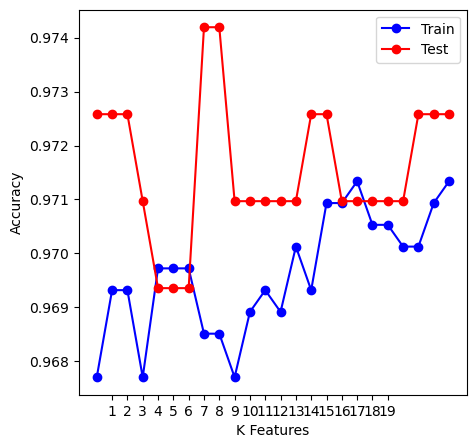

In [84]:
plt.figure(figsize=(5,5))
plt.plot(train_acc, c='blue', label='Train', marker='o')
plt.plot(test_acc, c='red', label='Test', marker='o')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('K Features')
plt.xticks(ticks=k_values)
plt.show()

In [85]:
train_acc = []
test_acc = []
c_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

for c_val in c_range:
    #1. Scale
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #2. Feature engineering
    my_pca = PCA(n_components=8)
    my_pca.fit(X_train_scaled, y_train)

    X_train_selected = my_pca.transform(X_train_scaled)
    X_test_selected = my_pca.transform(X_test_scaled)

    #3. Instantiate model
    my_log = LogisticRegression(C=c_val)
    my_log.fit(X_train_selected, y_train)
    
    train_val = my_log.score(X_train_selected, y_train)
    test_val = my_log.score(X_test_selected, y_test)
    
    train_acc.append(train_val)
    test_acc.append(test_val)

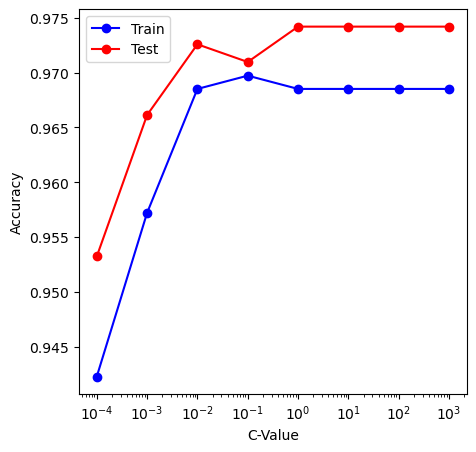

In [86]:
plt.figure(figsize=(5,5))
plt.plot(c_range, train_acc, c='blue', label='Train', marker='o')
plt.plot(c_range, test_acc, c='red', label='Test', marker='o')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('C-Value')
plt.xticks(ticks=range(1, 20, 2))
plt.xscale('log')
plt.show()

n_components = 8 seems to be the best with C = 1.

In [88]:
#1. Scale
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#2. Feature engineering
my_pca = PCA(n_components=8)
my_pca.fit(X_train_scaled, y_train)

X_train_selected = my_pca.transform(X_train_scaled)
X_test_selected = my_pca.transform(X_test_scaled)

#3. Instantiate model
my_log = LogisticRegression(C=1)
my_log.fit(X_train_selected, y_train)

#4. CV=5 Validation
cv_score = np.mean(cross_val_score(my_log, X_train_selected, y_train, cv=5))
print(f'CV score: {cv_score}')

print(f'Train score: {my_log.score(X_train_selected, y_train)}')
print(f'Test score: {my_log.score(X_test_selected, y_test)}')

CV score: 0.9668947539915281
Train score: 0.9685102947113444
Test score: 0.9741935483870968


This model has an accuracy of 97.4%. Our first Logistic Regression model was better at 97.8% accuracy so we will use that instead. As a reminder, here is that model:
- Scaler: StandardScaler
- Feature Engineering: SelectKBest(k = 7)
- Model: LogisticRegression(C = 1)

## Model Evaluation with Unseen Data<a name="fifth-point"></a>

Now, let's evaluate our model using the 20 rows we set aside to see how our model does on unseen data.

In [99]:
# Split to train and test data
X = testing_df.drop(columns=['all_nba_selections', 'name'])
y = testing_df['all_nba_selections']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


### Model

# Scale
first_scaler = StandardScaler()
first_scaler.fit(X_train)
    
X_train_ss = first_scaler.transform(X_train)
X_test_ss = first_scaler.transform(X_test)

# Feature engineering
my_KBest = SelectKBest(score_func=r_regression, k=7).fit(X_train_ss, y_train)
    
X_train_selected = my_KBest.transform(X_train_ss)
X_test_selected = my_KBest.transform(X_test_ss)
    
# Modeling
first_model = LogisticRegression(max_iter=10000, C=1)
first_model.fit(X_train_selected, y_train)

LogisticRegression(C=1, max_iter=10000)

In [100]:
# Get rows of unseen data
pred_rows = testing_df.iloc[untouched_index_list].drop(columns=['name', 'all_nba_selections'])

In [101]:
# Scale unseen data
pred_scaled = first_scaler.transform(pred_rows)

# Feature engineering
pred_kbest = my_KBest.transform(pred_scaled)

# Hard predictions
predictions = first_model.predict(pred_kbest)

In [102]:
# Create dataframe of unseen data
pred_df = testing_df.iloc[untouched_index_list]

In [103]:
# Create new column for hard predictions
pred_df['predictions'] = predictions

/var/folders/s_/j3ydldlx0dq_zfvvm27bphpr0000gn/T/ipykernel_15465/824251956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['predictions'] = predictions


In [104]:
# Check dataframe
pred_df = pred_df[['name', 'all_nba_selections', 'predictions']]
pred_df

,name,all_nba_selections,predictions
5,Tiny Archibald,1.0,0.0
756,Fat Lever,1.0,1.0
3096,Domantas Sabonis,1.0,0.0
2203,Al Jefferson,1.0,0.0
1711,Ben Wallace,1.0,0.0
64,Walt Frazier,1.0,1.0
342,Adrian Dantley,1.0,1.0
2168,Dwyane Wade,1.0,1.0
1225,Drazen Petrovic,1.0,0.0
397,Robert Parish,1.0,1.0


This looks pretty weak overall with 5 of the 10 true positives being labeled as negative.

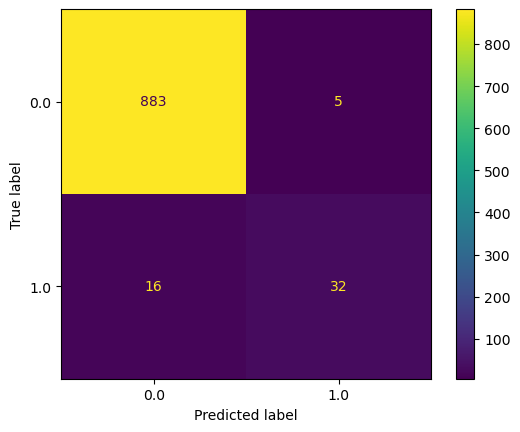

In [106]:
ConfusionMatrixDisplay.from_estimator(first_model, X_test_selected, y_test);

In [108]:
pred_test = first_model.predict(X_test_selected)

report_initial = classification_report(y_test, pred_test)
print(report_initial)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       888
         1.0       0.86      0.67      0.75        48

    accuracy                           0.98       936
   macro avg       0.92      0.83      0.87       936
weighted avg       0.98      0.98      0.98       936



This is a low recall and a decent precision score. We really would like to see recall go up. Let's change the thresholds to see if that helps these results. We're willing to sacrifice some precision (although not too much).

In [109]:
# Run probabilistic predictions
prob_pred = first_model.predict_proba(pred_kbest)

prob_pred

array([[6.63855890e-01, 3.36144110e-01],
       [4.58542536e-01, 5.41457464e-01],
       [9.98432163e-01, 1.56783745e-03],
       [6.07443837e-01, 3.92556163e-01],
       [7.90253932e-01, 2.09746068e-01],
       [2.11542788e-01, 7.88457212e-01],
       [3.11532334e-02, 9.68846767e-01],
       [6.47766199e-03, 9.93522338e-01],
       [8.97647670e-01, 1.02352330e-01],
       [3.96059019e-01, 6.03940981e-01],
       [9.98190676e-01, 1.80932432e-03],
       [9.99245929e-01, 7.54070600e-04],
       [9.93574226e-01, 6.42577396e-03],
       [9.94397035e-01, 5.60296482e-03],
       [9.93413382e-01, 6.58661818e-03],
       [9.98437507e-01, 1.56249312e-03],
       [9.95849265e-01, 4.15073491e-03],
       [9.99781845e-01, 2.18155309e-04],
       [9.99781845e-01, 2.18155309e-04],
       [9.99482191e-01, 5.17808645e-04]])

In [110]:
# Add positive probability to a new column in pred_df
pred_df['prob_predictions'] = [options[1] for options in prob_pred]

In [111]:
# Reset index and drop 'index' column
pred_df.reset_index(inplace=True)
pred_df.drop(columns='index', inplace=True)

In [112]:
pred_df

,name,all_nba_selections,predictions,prob_predictions
0,Tiny Archibald,1.0,0.0,0.336144
1,Fat Lever,1.0,1.0,0.541457
2,Domantas Sabonis,1.0,0.0,0.001568
3,Al Jefferson,1.0,0.0,0.392556
4,Ben Wallace,1.0,0.0,0.209746
5,Walt Frazier,1.0,1.0,0.788457
6,Adrian Dantley,1.0,1.0,0.968847
7,Dwyane Wade,1.0,1.0,0.993522
8,Drazen Petrovic,1.0,0.0,0.102352
9,Robert Parish,1.0,1.0,0.603941


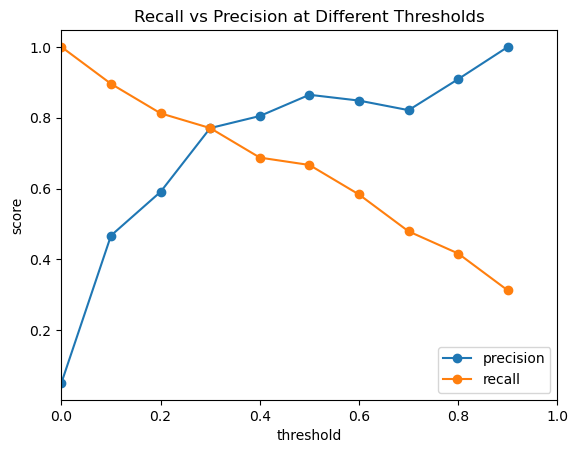

In [116]:
# Check tradeoff for recall, precision and accuracy scores with changing threshold

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_proba = first_model.predict_proba(X_test_selected)[:, 1]

# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0, 1, 0.1)

precisions = list()
recalls = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Recall vs Precision at Different Thresholds')
plt.legend()
plt.show()

In [121]:
# Create new column with hard predictions from the probabilistic prediction with different threshold
pred_df['from_prob_hard_predictions'] = [1 if num>=0.4 else 0 for num in pred_df['prob_predictions']]

In [122]:
pred_df

,name,all_nba_selections,predictions,prob_predictions,from_prob_hard_predictions
0,Tiny Archibald,1.0,0.0,0.336144,0
1,Fat Lever,1.0,1.0,0.541457,1
2,Domantas Sabonis,1.0,0.0,0.001568,0
3,Al Jefferson,1.0,0.0,0.392556,0
4,Ben Wallace,1.0,0.0,0.209746,0
5,Walt Frazier,1.0,1.0,0.788457,1
6,Adrian Dantley,1.0,1.0,0.968847,1
7,Dwyane Wade,1.0,1.0,0.993522,1
8,Drazen Petrovic,1.0,0.0,0.102352,0
9,Robert Parish,1.0,1.0,0.603941,1


In [123]:
# Create copy to revise
pred_df_revised = pred_df.copy()

In [124]:
# Check new scores with new threshold
report_initial = classification_report(pred_df_revised['all_nba_selections'], pred_df_revised['from_prob_hard_predictions'])
print(report_initial)

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        10
         1.0       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



Precision is the more important number for us. We want to be confident that when we predict a player will be predicted to be an All-NBA player, that player is actually All-NBA caliber. Therefore, assuming accuracy doesn't take a big dip, we'd like to see precision maximized. Right now, it's hard to say what threshold is best since recall takes a dive as precision goes up. Let's look at the test data to see if there is a more conclusive result.

## Model Evaluation with Test Data<a name="sixth-point"></a>

Now we'll evaluate our model on the test set.

In [125]:
# Create complete test set
asdf_df = X_test
asdf_df['all_nba'] = y_test
asdf_df.reset_index(inplace=True)

In [126]:
# Drop index column after reindexing
asdf_df.drop(columns='index', inplace=True)

In [127]:
# Sanity check
asdf_df.head()

,FTA,FT,PTS,FG,2P,FGA,2PA,TOV,DRB,AST,TRB,games_started,minutes_played,STL,BLK,ORB,PF,3PA,3P,games_played,VORP,WS,OWS,PER,BPM,OBPM,WS/48,AST%,TS%,DWS,all_nba
0,1.074074,0.777778,3.074074,1.074074,0.925926,3.444444,2.481481,0.777778,0.592593,0.814815,0.925926,0.000000,9.481481,0.518519,0.037037,0.333333,1.222222,0.962963,0.148148,27.0,-0.300000,-0.200000,-0.5000,6.00,-6.100000,-5.100000,-0.040000,15.100000,0.392000,0.300000,0.0
1,2.899638,2.333635,14.689873,5.330922,3.636528,11.809222,7.406872,1.504521,3.828210,1.679024,5.174503,0.808318,31.975588,1.055154,0.516275,1.346293,2.340868,4.402351,1.694394,1106.0,1.944444,5.216667,3.4500,14.75,0.627778,0.938889,0.101111,8.227778,0.543000,1.761111,0.0
2,0.950000,0.850000,4.750000,1.650000,1.050000,4.400000,3.000000,1.100000,1.450000,1.200000,1.750000,0.000000,13.450000,0.550000,0.000000,0.300000,0.700000,1.400000,0.600000,20.0,-0.100000,0.050000,-0.0500,10.15,-4.700000,-3.200000,0.009000,14.500000,0.500000,0.100000,0.0
3,1.218830,0.811705,3.580153,1.374046,1.353690,2.709924,2.671756,0.631043,2.506361,0.470738,4.050891,0.190840,15.905852,0.356234,0.279898,1.544529,2.458015,0.038168,0.020356,393.0,-0.025000,1.212500,0.6625,7.90,-4.725000,-3.562500,0.044750,3.025000,0.530375,0.537500,0.0
4,0.285714,0.142857,1.000000,0.428571,0.428571,1.857143,1.714286,0.571429,0.571429,0.285714,1.000000,0.000000,6.428571,0.142857,0.000000,0.428571,1.285714,0.142857,0.000000,7.0,-0.100000,-0.200000,-0.2000,-3.40,-11.000000,-9.700000,-0.165000,5.700000,0.252000,0.000000,0.0


In [128]:
# Separate target column
test_data_indexes = asdf_df.index

testing_rows = asdf_df.iloc[test_data_indexes].drop(columns=['all_nba'])

In [129]:
# Apply model and make predictions
testing_scaled = first_scaler.transform(testing_rows)

testing_kbest = my_KBest.transform(testing_scaled)

testing_predictions = first_model.predict(testing_kbest)

In [130]:
# Create hard predictions column
asdf_df['predictions'] = testing_predictions

In [132]:
# Get probability predictions
testing_prob_pred = first_model.predict_proba(testing_kbest)

testing_prob_pred

array([[9.99392536e-01, 6.07464195e-04],
       [7.46458757e-01, 2.53541243e-01],
       [9.99126042e-01, 8.73958031e-04],
       ...,
       [9.99046401e-01, 9.53599263e-04],
       [9.95953429e-01, 4.04657140e-03],
       [9.97139778e-01, 2.86022178e-03]])

In [133]:
# Store probability predictions in column
asdf_df['prob_predictions'] = [options[1] for options in testing_prob_pred]

In [183]:
# Create hard predictions from probability predictions with different threshold
asdf_df['from_prob_hard_predictions'] = [1 if num>=0.5 else 0 for num in asdf_df['prob_predictions']]

In [184]:
report_initial = classification_report(asdf_df['all_nba'], asdf_df['from_prob_hard_predictions'])
print(report_initial)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       888
         1.0       0.86      0.67      0.75        48

    accuracy                           0.98       936
   macro avg       0.92      0.83      0.87       936
weighted avg       0.98      0.98      0.98       936



In [185]:
print('Accuracy Score with New Threshold:')
accuracy_score(asdf_df['all_nba'], asdf_df['from_prob_hard_predictions'])

Accuracy Score with New Threshold:


0.9775641025641025

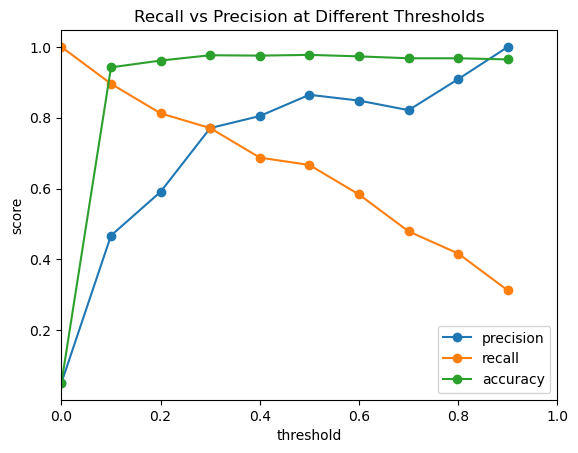

In [187]:
# See different precision and recall scores with different thresholds
y_proba = asdf_df['prob_predictions']

# Vary thresholds by 0.1 from 0 to 0.9
thresholds = np.arange(0, 1, 0.1)

precisions = list()
recalls = list()
accuracies = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(asdf_df['all_nba'], y_threshold)
    recall = recall_score(asdf_df['all_nba'], y_threshold)
    accuracy = accuracy_score(asdf_df['all_nba'], y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.plot(thresholds, accuracies, label='accuracy', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Recall vs Precision at Different Thresholds')
plt.legend()
plt.show()

Here we see a threshold of 0.5 seems to be the best all around. Recall hasn't completely tanked while precision is still relatively high. And accuarcy is at its highest at 0.5. Therefore, that's what we'll leave it at.

- Accuracy: 97.8%
- Precision: 86%
- Recall: 67%

## Conclusion<a name="seventh-point"></a>

Overall, our model does what we need it to do. Its accuracy of 97.8% is better than chance. The precision is solid without sacrificing too much recall.

The limitations of this model (and any model most likely) is the inconsistency of why players make an All-NBA team. Defensive-focused players will likely make less All-NBA teams even though their VORP or WS is high (the two strongest factors in All-NBA prediction).

We will miss some players in our predictions, but we can be confident that those we predict as All-NBA caliber are almost certainly that. Therefore, we can examine what makes these players successful and translate that into recruiting and building up players to be successful with their teams.

## Gradio Launch<a name="eighth-point"></a>

Use this Gradio app to interact with the model a little bit!

In [267]:
def all_nba_prediction(name_input, vorp_input, ws_input, pts_input, assists_input, rebounds_input):
    help_df = final_df.drop(columns=['all_nba_selections', 'name'])
    
    # Create input array - Use means of non-input values as placeholder values for demo
    # Used some ratios to create more accuracy in estimate
    input_array = np.array([[
        help_df['FTA'].mean(), 
        help_df['FT'].mean(), 
        pts_input, 
        help_df['FG'].mean(), 
        help_df['2P'].mean(),
        help_df['FGA'].mean(), 
        help_df['2PA'].mean(), 
        help_df['TOV'].mean(), 
        help_df['DRB'].mean() / help_df['TRB'].mean() * rebounds_input, 
        assists_input,
        rebounds_input, 
        help_df['games_started'].mean(), 
        help_df['minutes_played'].mean(), 
        help_df['STL'].mean(),
        help_df['BLK'].mean(), 
        help_df['ORB'].mean() / help_df['TRB'].mean() * rebounds_input, 
        help_df['PF'].mean(), 
        help_df['3PA'].mean(),
        help_df['3P'].mean(), 
        help_df['games_played'].mean(), 
        vorp_input, 
        ws_input,
        help_df['OWS'].mean() / help_df['WS'].mean() * ws_input, 
        help_df['PER'].mean(), 
        help_df['BPM'].mean(), 
        help_df['OBPM'].mean(),
        help_df['WS/48'].mean() / help_df['WS'].mean() * ws_input, 
        help_df['AST%'].mean(), 
        help_df['TS%'].mean(), 
        help_df['DWS'].mean() / help_df['WS'].mean() * ws_input
    ]])
    
    
    # Scale input data
    app_scaled = first_scaler.transform(input_array)
    
    # Feature engineer input data
    app_kbest = my_KBest.transform(app_scaled)
    
    # Probability prediction of input data
    prob_pred = first_model.predict_proba(app_kbest)
    
    # Output input data
    if prob_pred[0][1] >= 0.4:
        message = f'{name_input} has an All-NBA stat line!'
    else:
        message = f'{name_input} does not have an All-NBA stat line.'
    
    return message


# Create inputs
name_input = gr.Textbox(label = "What's your player's name?", show_label = True)
vorp_input = gr.Slider(label = "Enter VORP of player (-1 - 13):", maximum=13, minimum=-1, value=0)
ws_input = gr.Slider(label = "Enter WS of player (-1 - 22):", maximum=22, minimum=-1, value=0)
pts_input = gr.Number(label = "Enter Points per Game of player:", minimum=0)
assists_input = gr.Number(label = "Enter Assists per Game of player:", minimum=0)
rebounds_input = gr.Number(label = "Enter Rebounds per Game of player:", minimum=0)

# Create output
output = gr.Textbox()


# Interface
app = gr.Interface(fn=all_nba_prediction, 
                    inputs=[name_input, vorp_input, ws_input, pts_input, assists_input, rebounds_input], 
                    outputs=output)

# Launch
app.launch(debug=True)

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/aidenbailey/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Keyboard interruption in main thread... closing server.
